# Leikecase

Datasett: *Marine Mammals Sightings in and around Svalbard 1995-2019*
Inneheld rapporterte observasjoner av marine pattedyr på og rundt Svalbard i tidsperioden 1995-2019. Dataen består av tidspunkt, lokasjon, art og antall individ observert.

Kolonne | Forklaring
-- |-- 
eventID | Unik identifikator
coordinateUncertaintyInMeters | Usikkerheit i koordinatane
decimalLatitude | Breddegrad i WGS-84. -90.0 til 90.0
decimalLongitude | Lengegrad i WGS-84. -180.0 til 180.0
scientificName | Artsnamn på latinsk
eventDate | Tidspunkt for observasjonen.
individualCount | Antall individ observert

In [100]:
import pandas as pd
import numpy as np

In [101]:
# Tving pandas til å vise alle kolonnene i output
pd.set_option('display.max_columns', None)

## Hente data

Mål:
- Laste inn CSV for observasjonar
- Laste inn CSV for artsnamn på norsk

In [102]:
observations = pd.read_csv("data/MMSDB_observations_1995-2019-v2.csv", delimiter="$")
animals = pd.read_csv("data/animals.csv")

Oppgåver:
- Kor mange observasjonar har det blitt gjort totalt?
- Kor mange ulike arter har det blitt rapportert observasjonar på?

In [104]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22878 entries, 0 to 22877
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   eventID                              22878 non-null  object 
 1   basisOfRecord                        22878 non-null  object 
 2   coordinateUncertaintyInMeters        0 non-null      float64
 3   decimalLatitude                      22487 non-null  float64
 4   decimalLongitude                     22474 non-null  float64
 5   eventDate                            22683 non-null  object 
 6   eventRemarks                         9932 non-null   object 
 7   habitat                              20059 non-null  object 
 8   individualCount                      22640 non-null  float64
 9   licence                              22878 non-null  object 
 10  locality                             13715 non-null  object 
 11  locationRemarks             

In [70]:
observations["scientificName"].unique()

array(['Delphinapterus leucas', 'Ursus maritimus', 'Pusa hispida',
       'Pagophilus groenlandicus', 'Balaenoptera acutorostrata',
       'Balaenoptera physalus', 'Physeter macrocephalus',
       'Hyperoodon ampullatus', 'Erignathus barbatus', 'Phoca vitulina',
       'Odobenus rosmarus', 'Balaena mysticetus',
       'Megaptera novaeangliae', 'Cystophora cristata',
       'Monodon monoceros', 'Cetacea', 'Lagenorhynchus albirostris',
       'Orcinus orca', nan, 'Balaenoptera musculus', 'Pinnipedia',
       'Phocoena phocoena', 'Balaenoptera borealis', 'Globicephala melas',
       'Lagenorhynchus acutus'], dtype=object)

In [71]:
animals.head()

,scientificName,norwegianName
0,Balaena mysticetus,Grønlandshval
1,Balaenoptera acutorostrata,Vågehval
2,Balaenoptera borealis,Seihval
3,Balaenoptera musculus,Blåhval
4,Balaenoptera physalus,Finnhval


## Rense og forberede data

Mål:
- Fjerne alle rader utan koordinatar eller observasjonstidspunkt
- Parse tidspunkt til pandas.Timestamp
- Joine inn norske namn til observasjonane
- Opprett ein dataframe som kun ser på isbjørnar

In [108]:
observations = observations[
    (~observations["eventDate"].isna())
    & (~observations["decimalLongitude"].isna())
    & (~observations["decimalLatitude"].isna())
]

In [109]:
observations = pd.merge(observations, animals, on="scientificName")

In [110]:
observations.columns

Index(['eventID', 'basisOfRecord', 'coordinateUncertaintyInMeters',
       'decimalLatitude', 'decimalLongitude', 'eventDate', 'eventRemarks',
       'habitat', 'individualCount', 'licence', 'locality', 'locationRemarks',
       'scientificName', 'taxonID', 'dynamicProperties.adult',
       'dynamicProperties.adultF', 'dynamicProperties.adultM',
       'dynamicProperties.bearCubs', 'dynamicProperties.comment',
       'dynamicProperties.cubCalfPup', 'dynamicProperties.deadAlive',
       'dynamicProperties.endDate', 'dynamicProperties.infoComment',
       'dynamicProperties.organisation', 'dynamicProperties.otherSpecies',
       'dynamicProperties.platform', 'dynamicProperties.platformComment',
       'dynamicProperties.polarBearDen', 'dynamicProperties.editorComment',
       'dynamicProperties.editorDate', 'dynamicProperties.editorQualityTest',
       'timestamp', 'year', 'norwegianName'],
      dtype='object')

In [111]:
observations.describe()

,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,individualCount,dynamicProperties.adult,dynamicProperties.adultF,dynamicProperties.adultM,dynamicProperties.bearCubs,dynamicProperties.cubCalfPup,year
count,0.0,21951.000000,21951.000000,21917.000000,5551.000000,1396.000000,1546.000000,104.000000,1325.000000,21951.000000
mean,NaN,78.201229,15.692124,9.244148,11.272203,3.553009,6.972186,1.346154,3.167547,2011.343492
std,NaN,2.232917,8.936682,102.897454,192.670744,23.787938,19.376425,0.650157,8.205205,4.218584
min,NaN,57.127778,-42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1995.000000
25%,NaN,77.100000,11.759210,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2008.000000
50%,NaN,78.779150,15.363333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2012.000000
75%,NaN,79.730955,20.731950,4.000000,4.000000,1.000000,3.000000,2.000000,2.000000,2014.000000
max,NaN,89.630000,80.470000,10000.000000,10000.000000,600.000000,300.000000,6.000000,150.000000,2019.000000


In [112]:
observations["timestamp"] = observations["eventDate"].apply(lambda ed: pd.Timestamp(ed))

In [113]:
observations.head()

,eventID,basisOfRecord,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,eventDate,eventRemarks,habitat,individualCount,licence,locality,locationRemarks,scientificName,taxonID,dynamicProperties.adult,dynamicProperties.adultF,dynamicProperties.adultM,dynamicProperties.bearCubs,dynamicProperties.comment,dynamicProperties.cubCalfPup,dynamicProperties.deadAlive,dynamicProperties.endDate,dynamicProperties.infoComment,dynamicProperties.organisation,dynamicProperties.otherSpecies,dynamicProperties.platform,dynamicProperties.platformComment,dynamicProperties.polarBearDen,dynamicProperties.editorComment,dynamicProperties.editorDate,dynamicProperties.editorQualityTest,timestamp,year,norwegianName
0,275d07fc-7cd9-cd10-7731-b01ed6ddd89b,HumanObservation,NaN,78.057,15.675,1995-04-01T12:00:00Z,bear killing and feeding on reindeer,land,1.0,All rights reserved,NaN,NaN,Ursus maritimus,http://www.marinespecies.org/aphia.php?p=taxde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Old id:5067, field activity id:166 Platform: S...",NaN,NaN,ship,NaN,NaN,NaN,2020-10-20T12:00:00Z,NaN,1995-04-01 12:00:00+00:00,1995.0,Isbjørn
1,275d07fc-7cd9-cd10-7731-b01ed6dde77e,HumanObservation,NaN,77.533,20.875,1998-08-01T12:00:00Z,bear trying to kill reindeer,land,1.0,All rights reserved,NaN,NaN,Ursus maritimus,http://www.marinespecies.org/aphia.php?p=taxde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Old id:5068, field activity id:166 Platform: S...",NaN,NaN,ship,NaN,NaN,NaN,2020-10-20T12:00:00Z,NaN,1998-08-01 12:00:00+00:00,1998.0,Isbjørn
2,275d07fc-7cd9-cd10-7731-b01ed66cbdf4,HumanObservation,NaN,79.656,13.220,2000-07-27T12:00:00Z,NaN,water,1.0,All rights reserved,Liefdefjorden,N end,Ursus maritimus,http://www.marinespecies.org/aphia.php?p=taxde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-08-15T12:00:00Z,"Old id:248, field activity id:36 Platform: Shi...",NaN,NaN,ship,Prof Multanovskiy,NaN,NaN,2020-10-20T12:00:00Z,NaN,2000-07-27 12:00:00+00:00,2000.0,Isbjørn
3,275d07fc-7cd9-cd10-7731-b01ed66cb97d,HumanObservation,NaN,79.556,12.517,2000-07-27T12:00:00Z,1 females. 1 males,NaN,7.0,All rights reserved,Monaccobreen,NaN,Ursus maritimus,http://www.marinespecies.org/aphia.php?p=taxde...,2.0,NaN,NaN,NaN,NaN,1.0,NaN,2000-08-15T12:00:00Z,"Old id:247, field activity id:36 Platform: Shi...",NaN,NaN,ship,Prof Multanovskiy,NaN,NaN,2020-10-20T12:00:00Z,NaN,2000-07-27 12:00:00+00:00,2000.0,Isbjørn
4,275d07fc-7cd9-cd10-7731-b01ed66cc18a,HumanObservation,NaN,78.827,26.488,2000-07-29T12:00:00Z,NaN,NaN,8.0,All rights reserved,Svenskøya,N side,Ursus maritimus,http://www.marinespecies.org/aphia.php?p=taxde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-08-15T12:00:00Z,"Old id:249, field activity id:36 Platform: Shi...",NaN,NaN,ship,Prof Multanovskiy,NaN,NaN,2020-10-20T12:00:00Z,NaN,2000-07-29 12:00:00+00:00,2000.0,Isbjørn


## Transformere data

- Opprett ei ny kolonne "year" basert på tidspunkt
- Lag ein ny dataframe som er aggregert per art og år.
- Per gruppe:
    - Summer opp totalt antall individ
    - Tell opp kor mange observasjonar som har blitt gjort

In [114]:
observations["year"] = observations["timestamp"].apply(lambda t: t.year)
observations = observations[
    (observations["year"] >= 1995) &
    (observations["year"] <= 2019)
]
observations_isbjørn = observations[observations["norwegianName"] == "Isbjørn"]

In [115]:
observations_isbjørn_grouped = observations_isbjørn.groupby(["norwegianName", "year"]).agg(
    total_individuals=("individualCount", np.sum),
    num_sightings=("eventID", np.count_nonzero)
).reset_index().sort_values(by=["norwegianName", "year"], ascending=True)

/tmp/ipykernel_4319/3460433815.py:1: FutureWarning: The provided callable <function sum at 0x7f329077ea20> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  observations_isbjørn_grouped = observations_isbjørn.groupby(["norwegianName", "year"]).agg(


In [119]:
observations_isbjørn_grouped

,norwegianName,year,total_individuals,num_sightings
0,Isbjørn,1995,1.0,1
1,Isbjørn,1998,1.0,1
2,Isbjørn,2000,30.0,11
3,Isbjørn,2002,19.0,12
4,Isbjørn,2003,22.0,9
5,Isbjørn,2004,124.0,59
6,Isbjørn,2005,137.0,74
7,Isbjørn,2006,838.0,294
8,Isbjørn,2007,221.0,119
9,Isbjørn,2008,277.0,184


In [126]:
observations_piv = observations.pivot_table(
    "individualCount", 
    index="year", 
    columns="norwegianName", 
    aggfunc="sum"
)

In [127]:
observations_piv.fillna(0, inplace=True)

In [128]:
observations_piv.head()

norwegianName,Blåhval,Finnhval,Grindhval,Grønlandshval,Grønlandssel,Hvaler,Hvalross,Hvithval,Isbjørn,Klappmyss,Knølhval,Kvitnos,Kvitskjeving,Narhval,Nebbhval,Nise,Ringsel,Seihval,Seldyr,Spekkhogger,Spermhval,Steinkobbe,Storkobbe,Vågehval
year,,,,,,,,,,,,,,,,,,,,,,,,
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2000,0.0,0.0,0.0,3.0,283.0,0.0,308.0,1.0,30.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,41.0,0.0,0.0,0.0,1.0,2.0,65.0,1.0
2001,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,2.0,40.0,0.0,0.0,160.0,2.0,332.0,50.0,19.0,11.0,31.0,220.0,0.0,50.0,0.0,0.0,21.0,0.0,0.0,36.0,5.0,0.0,44.0,39.0


## Plotting og visualisering

- Plott antall observerte isbjørnar per år
- Per år, plott antall isbjørnar og hvalrossar
- Etter 2017, vis alle obervasjonar for isbjørnar i folium
    - Rekn ut middels breddegrad og lengdegrad
    - Plott alle observasjonar
    - Legg til tidspunkt, koordinatar og antall individ i popup
    - Lagre kart som til disk

### Antall isbjørnar per år

<Axes: xlabel='year'>

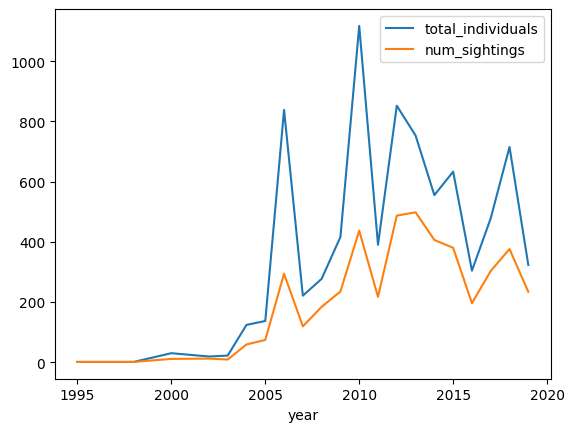

In [129]:
observations_isbjørn_grouped.plot(x="year", secondary_y=["individuals_per_sighting"])

### Isbjørnar og kvalrossar

In [130]:
observations_subplots = observations_piv[["Isbjørn", "Hvalross"]]

<Axes: xlabel='year'>

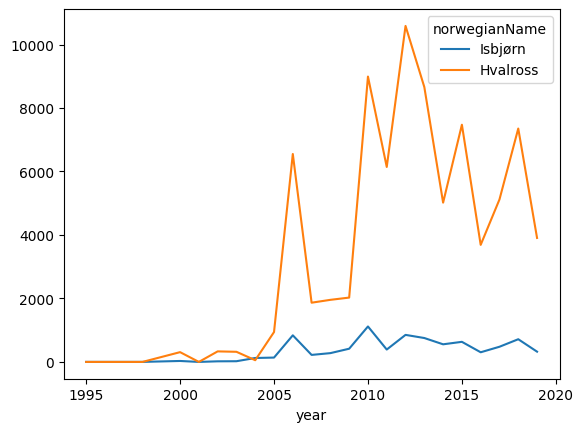

In [131]:
observations_subplots.plot()

### Folium og kart

In [132]:
mean_latitude = observations_isbjørn["decimalLatitude"].mean()
mean_latitude

79.28416645164162

In [133]:
mean_longitude = observations_isbjørn["decimalLongitude"].mean()
mean_longitude

18.253018769462432

In [140]:
import folium

m = folium.Map(
    location=(mean_latitude, mean_longitude),
    zoom_start=4.5
)
m

In [141]:
for idx, row in observations_isbjørn[
    observations_isbjørn["year"] >= 2017
].iterrows():
    lat = row["decimalLatitude"]
    lng = row["decimalLongitude"]
    folium.Marker(
        location=[lat, lng],
        popup=f"""
        Timestamp: {row["timestamp"]}
        Individuals: {row["individualCount"]}
        Location: ({lat:.3f}, {lng:.3f})
        """
    ).add_to(m)

In [142]:
m

In [143]:
m.save("data/map.html")